# Mineral Potential Mapping with Python - A Practical Tool

In this notebook, a simple but practical tool has been developed with python which helps with geochemical modelling. The core of all of the processes is based on an article by Mahyar Yousefi and Emmanuel Carranza <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). According to the article, assignment of weights to different classes of evidence in an evidential map is usually done through expert's opinion with some trial-and-error. In order to do this process in a data-driven way rather than using expert's opinion, a new method using prediction-area (P-A) plots and normalized density is introduced to determine weights of every single evidential map. In the following lines the literature disccused in the aforementioned work is programmed in Python.

The programming language used in here is python. There are several reasons for the choice. The most important ones is that this language is agile and is easy to read and develop. Researchers can easily modify the code based on their needs.

This program has been developed in three parts. The first Part, [Part 1](#Part1), is where all the preprocessing happens - from installing/importing the necessary libraries to statistical analysis of the data. The second Part, [Part 2](#Part2), is where the core of the processes has been programmed - gridding, mapping, PC analysis, Concentration-Area fractal modelling, descretizing, and Prediction-Area diagram drawing. The [final part](#future) is dedicated to discussion current issues with the code and suggestions for future development.

## Table of Contents

1. [Part 1](#Part1)
    1. [Libraries](#Libraries)
    2. [Data](#data)
    3. [Input Variables](#var)
    4. [Statistical Analysis](#stats)
        1. [Basic Statistics](#basicstats)
        2. [Pearson and Spearman Correlation Coefficients](#corr)
        3. [Statistical Plots](#statplots)
2. [Part 2](#Part2)
    1. [Gridding](#gridding)
    2. [Mapping](#mapping)
    3. [Principal Component Analysis](#pca)
    4. [Concentration-Area Fractal Modelling](#ca)
    5. [Determining Threseholds for Classes of an Evidential Map](#discrete)
    6. [Prediction-Area (P-A) Diagrams](#pa)
    7. [Integrating Evidential Layers](#io)
    8. [Model Evaluation](#eval)
3. [Future Developments](#future)
4. [References](#refer)

## Part 1 <a name="Part1"></a>

Preprocessing starts here. This stage includes: installing/importing the necessary libraries, creating a pandas DataFrame and importing the data, importing all the necessary variables, and analyzing the data statistically.

### Libraries <a name="Libraries"></a>

This program relies on several well-known libraries including `numpy`, `pandas`, `matplotlib`, `scikit-learn`, and `scipy`. This program is designed to have the fewest number of dependencies. Please make sure you have the packages installed. Otherwise, go on and uncomment lines in the following box to install them.

In [1]:
#import sys
#!{sys.executable} -m pip install numpy pandas matplotlib sklearn scipy

In case the packages have been installed, we only need to import them.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import griddata
from scipy.stats import describe, probplot, stats
from scipy import interpolate
from math import *

### Data <a name="data"></a>


In the following cell, the data, which is a csv file, is imported into a Pandas DataFrame. This helps with handling the data in the most flexible way possible and makes data processing much easier than any other data handling method. After importing, some minor processings are done to polish the data; like dropping empty cells and duplicates from the dataframe.

By default, the program reads the file from the same directory as it is in. But the user can give the desired file path to the program as long as it is a csv file. In case importing an excel file, please read the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) for modifying the code accordingly.

In [40]:
def preprocess(location):
    
    data = pd.read_csv(location)
    data = data.replace("", np.nan)
    data = data.dropna()
    data = data.drop_duplicates().loc[:, 'X':]
    
    return data

It's best that the user sees the first few lines of the main csv file, which is now imported to a DataFrame. This can be acheived by calling the `preprocess` function.

In [32]:
preprocess('Data.csv')

,X,Y,Zn,Pb,Ag,Cu,Mo,Cr,Ni,Co,Ba
0,431434.79,3305001.94,87,7,0.02,42,2,57,38,14,393
1,432522.60,3298058.43,70,6,0.02,56,2,27,29,20,404
2,438045.35,3291987.05,75,5,0.02,69,2,44,23,17,417
3,436260.76,3294412.90,70,6,0.02,54,1,20,19,12,377
4,439294.48,3297653.81,168,14,0.02,27,2,31,18,14,277
...,...,...,...,...,...,...,...,...,...,...,...
841,414614.38,3300475.33,113,15,0.02,72,2,78,48,33,467
842,413559.89,3299053.77,92,14,0.02,73,1,60,48,30,380
843,423054.28,3292767.47,154,30,0.02,54,2,65,35,26,439
844,424400.10,3293090.75,395,58,0.02,55,2,81,106,24,531


This data belongs to an area in south eastern regions of Iran. This DataFrame includes cartesian coordinates, and 9 element concenterations. All of the following processes are done using this dataset. 

### Input Variables<a name="var"></a>

There are several variables that the user needs to enter so the program can run. Here, the user enters all of them together so there wouldn't be much confusion over them further down the file. Different interpolation methods are discussed in the [gridding](#gridding) section.

In [33]:
input_elements = input("\n For what columns should the geochemical processes be done? "
                       "\n Please use 'space' as a separator. \n")
# Zn Pb Ag Cu Mo Cr Ni Co Ba

input_X = input(" Which column corresponds with X axis of the Catesian system?\n")
# X

input_Y = input("\n Which column corresponds with Y axis of the Catesian system?\n")
# Y

input_interpol = input("\n Which interpolation method should be used? cubic, linear, or nearest? "
                       "Please write the desired one.\n")
# linear


 For what columns should the geochemical processes be done? 
 Please use 'space' as a separator. 
Zn Pb Ag Cu Mo Cr Ni Co Ba
 Which column corresponds with X axis of the Catesian system?
X

 Which column corresponds with Y axis of the Catesian system?
Y

 Which interpolation method should be used? cubic, linear, or nearest? Please write the desired one.
linear


### Statistical Analysis<a name="stats"></a>

The data should be statistically examined so the user can have a grasb on the data structure. In the next parts, some tools for basic statistics have been developed. 

#### Basic Statistics <a name="basicstats"></a>

A function has been developed which returns the number of observations, minimum and maximum of the data for each column, arithmatic mean, variance, skewness, and kurtosis. All of these calculations, then, are stored in a `list` for use in further steps.

In [36]:
def basic_stats(element_concentration):
    
    raw_data = preprocess('Data.csv')
    selected_values = describe(raw_data.loc[:,f'{element_concentration}'].values)

    s1 = str(selected_values.nobs)
    s2 = str(selected_values.minmax[0])
    s3 = str(selected_values.minmax[1])
    s4 = str(round(selected_values.mean, 2))
    s5 = str(round(selected_values.variance, 2))
    s6 = str(round(selected_values.skewness, 2))
    s7 = str(round(selected_values.kurtosis, 2))

    return [s1,s2,s3,s4,s5,s6,s7]

We need to iterate this function for our desired columns, which in this case is all of the 9 columns containing element concentration. The next block iterates this process for all of the given elements and stores them in a  DataFrame.

In [37]:
def basic_stats_df(element_concentration):

    raw_data = preprocess('Data.csv')
    columns = ['No. of Observations', 'Min', 'Max', 'Mean', 'Variance', 'Skewness', 'Kurtosis']
    index_names = element_concentration.split()
    df = pd.DataFrame(columns=columns)

    data = []
    selected_columns = raw_data.loc[:, index_names].columns
    for counter, column in enumerate(selected_columns):
        values = basic_stats(element_concentration=column)
        zipped = zip(columns, values)
        data.append(dict(zipped))
        

    df = df.append(data,True)

    index = pd.Index(index_names)
    df = df.set_index(index)

    return df

Now that all is set, let's call in the above function to get our hands on basic statistics.

In [41]:
basic_stats_df(input_elements)

,No. of Observations,Min,Max,Mean,Variance,Skewness,Kurtosis
Zn,846,2,752,113.81,6459.84,2.57,11.51
Pb,846,2,321,23.82,639.82,6.11,56.93
Ag,846,0.02,1.0,0.03,0.01,11.75,136.01
Cu,846,2,1200,65.07,2856.14,13.27,255.58
Mo,846,1,12,1.73,1.07,4.13,29.63
Cr,846,7,1200,120.74,13063.54,3.41,18.32
Ni,846,2,1200,68.02,3993.93,7.91,123.54
Co,846,2,247,28.66,249.24,4.54,51.95
Ba,846,15,4650,424.46,50244.0,8.25,148.27


#### Pearson and Spearman Correlation Coefficients <a name="corr"></a>
The [Pearson correlation coefficient](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php) is a measure of the strength of a linear association between two variables. The Pearson correlation coefficient can take a range of values from +1 to -1. A value of 0 indicates that there is no association between the two variables. A value greater than 0 indicates a positive association; that is, as the value of one variable increases, so does the value of the other variable. A value less than 0 indicates a negative association; that is, as the value of one variable increases, the value of the other variable decreases. This is shown in the diagram below:

<img src="https://statistics.laerd.com/statistical-guides/img/pc/pearson-1-small.png" alt="pearson correlation coefficient" href="https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php" width=500px>

The [Spearman's rank-order correlation](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php) is the nonparametric version of the Pearson correlation. Spearman's correlation coefficient, measures the strength and direction of association between two ranked variables. The Spearman correlation coefficient can take values from +1 to -1 as well. A coefficient of +1 indicates a perfect association of ranks, a coefficient of zero indicates no association between ranks, and a coefficeint of -1 indicates a perfect negative association of ranks. The closer this coefficient is to zero, the weaker the association between the ranks.

In the next to code blocks, first a function is developed to calculate these two correlation coefficients, then iterates this function over the other elements and returns each coefficient in a separate DataFrame.

In [42]:
def correlation(first_element, second_element):
    
    raw_data = preprocess('Data.csv')

    first_elem, second_elem = raw_data.loc[:, f'{first_element}'], raw_data.loc[:, f'{second_element}']
    spearcorr = list(stats.spearmanr(first_elem, second_elem))
    pearcorr = list(stats.pearsonr(first_elem, second_elem))
    
    spearcorr = round(spearcorr[0], 3)
    pearcorr = round(pearcorr[0], 3)

    return pearcorr, spearcorr

In [43]:
def correlation_iterated(element_concentration):

    raw_data = preprocess('Data.csv')
    columns = index_names = element_concentration.split()
    
    data1 = {}
    data2 = {}
    selected_columns = raw_data.loc[:,columns].columns   
    for i in selected_columns:
        temp1 = []
        temp2 = []
        for j in selected_columns:
            a, b = correlation(first_element=i,second_element=j)
            temp1.append(a)
            temp2.append(b)

        data1[i] = temp1
        data2[i] = temp2
    
    
    df1 = pd.DataFrame(data1,index_names)
    df2 = pd.DataFrame(data2,index_names)

    
    print('Here is the Pearson correlation coefficient for elements:\n', df1 , '\n')
    print('Here is the Spearman correlation coefficient for elements:\n', df2)

In [44]:
correlation_iterated(input_elements)

Here is the Pearson correlation coefficient for elements:
        Zn     Pb     Ag     Cu     Mo     Cr     Ni     Co     Ba
Zn  1.000  0.360  0.371  0.153 -0.136  0.399  0.203  0.218  0.051
Pb  0.360  1.000  0.088  0.147 -0.094  0.167  0.064  0.037  0.191
Ag  0.371  0.088  1.000  0.074 -0.046  0.050  0.045  0.108 -0.005
Cu  0.153  0.147  0.074  1.000  0.061  0.081  0.084  0.248  0.076
Mo -0.136 -0.094 -0.046  0.061  1.000 -0.105  0.021  0.069  0.047
Cr  0.399  0.167  0.050  0.081 -0.105  1.000  0.498  0.394 -0.095
Ni  0.203  0.064  0.045  0.084  0.021  0.498  1.000  0.558 -0.071
Co  0.218  0.037  0.108  0.248  0.069  0.394  0.558  1.000  0.010
Ba  0.051  0.191 -0.005  0.076  0.047 -0.095 -0.071  0.010  1.000 

Here is the Spearman correlation coefficient for elements:
        Zn     Pb     Ag     Cu     Mo     Cr     Ni     Co     Ba
Zn  1.000  0.461  0.128  0.276 -0.165  0.402  0.175  0.166 -0.044
Pb  0.461  1.000  0.112  0.304 -0.191  0.338  0.097 -0.005  0.174
Ag  0.128  0.112  1.0

#### Statistical Plots<a name="statplots"></a>
The four main statistical plots are histogram, box plot, P-P plot, and Q-Q plot. 

A [histogram](https://statistics.laerd.com/statistical-guides/understanding-histograms.php) is a plot that lets you discover, and show, the underlying frequency distribution (shape) of a set of continuous data. This allows the inspection of the data for its underlying distribution (e.g., normal distribution), outliers, skewness, etc.

A [boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" alt="a sample boxplot" href="https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51" width=600px>

[P-P](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703) (probability–probability) plot is a visualization that plots comulative distribution functions of the two distributions (empirical and theoretical) against each other.

Similarly to P-P plots, [Q-Q](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703) (quantile-quantile) plots allow us to compare distributions by plotting their quantiles against each other.

In the next two cells, first all of these are calculated each in a function, then the function is iterated and  plots of all elements are shown to the user.

In [45]:
def statistical_plots(desired_column):
    
    raw_data = preprocess('Data.csv')
    values = raw_data.loc[:,f'{desired_column}'].values
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8,8])
    
    
    #plot1 => histogram
    plot1 = axes[0, 0].hist(values, bins=50,color='c', edgecolor='k', alpha=0.65)
    plot1 = axes[0, 0].axvline(values.mean(), color='k', linestyle='--', linewidth=1)
    min_ylim, max_ylim = axes[0, 0].set_ylim() 
    plot1 = axes[0, 0].text(values.mean()*1.4, max_ylim*0.9, 'Mean: {:.2f}'.format(values.mean()))
    plot1 = axes[0, 0].set(title = f'Histogram chart for {desired_column}')
    
    #plot2 => boxplot
    plot2 = axes[0, 1].boxplot(values, vert=False, patch_artist=False,sym='', showmeans=True)
    plot2 = axes[0, 1].set(title = f'Box plot for {desired_column}')
    plot2 = axes[0, 1].grid(axis = 'x')
    
    #plot3 => Q-Q plot
    plot3 = probplot(values, plot=axes[1, 0])
    plot3 = axes[1, 0].set(title = f'Q-Q plot of {desired_column}')
    plot3 = axes[1, 0].grid(True)
    
    #plot4 => P-P plot
    norm = np.random.normal(0, 1, len(values))
    norm = norm - (min(norm) - min(values))
    min_value = min(norm)
    scale = (max(values) - min_value) / (max(norm) - min_value)
    norm = np.apply_along_axis(lambda x : min_value + (x-min_value)*scale, axis=0, arr=norm)
    norm.sort()
    values.sort()
    bins = np.percentile(norm, np.linspace(0, 100, 1000))
    data_hist, _ = np.histogram(values, bins=bins)
    cumsum_data = np.cumsum(data_hist)
    cumsum_data = np.array(cumsum_data) / max(cumsum_data)
    norm_hist, _ = np.histogram(norm, bins=bins)
    cumsum_norm = np.cumsum(norm_hist)
    cumsum_norm = np.array(cumsum_norm) / max(cumsum_norm)
    
    plot4 = axes[1, 1].plot(cumsum_norm, cumsum_data, 'o')
    plot4 = axes[1, 1].plot([0, 1], [0, 1], color='r')
    plot4 = axes[1, 1].set(title = f'P-P plot of {desired_column}')
    plot4 = axes[1, 1].grid(True)
    
    
    
    plt.suptitle(f'Basic Statistical Plots of {desired_column}')
    fig.tight_layout()
    plt.show()
    

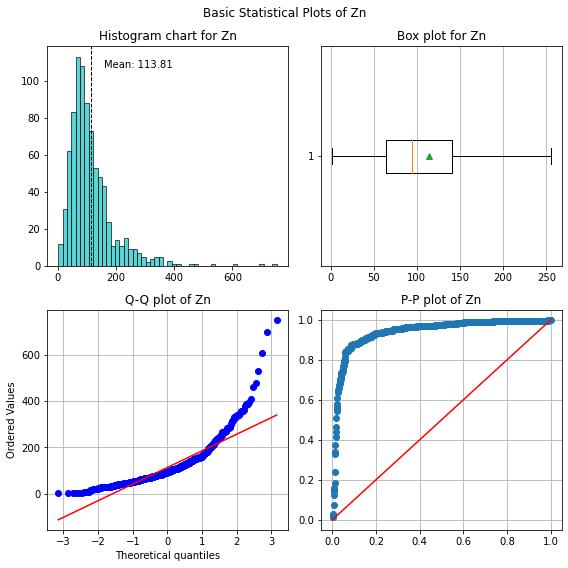

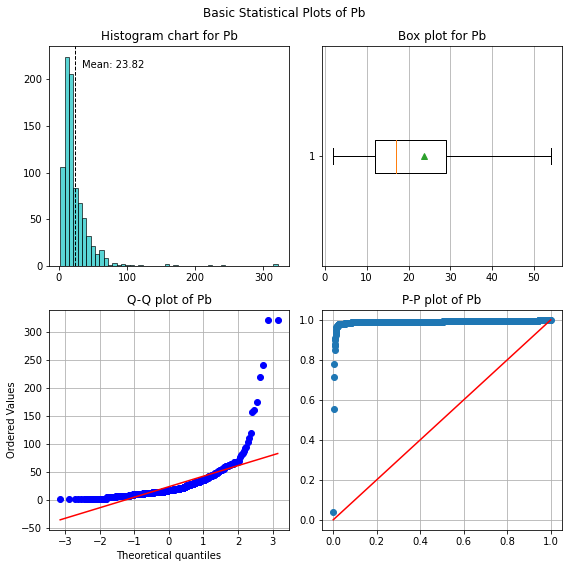

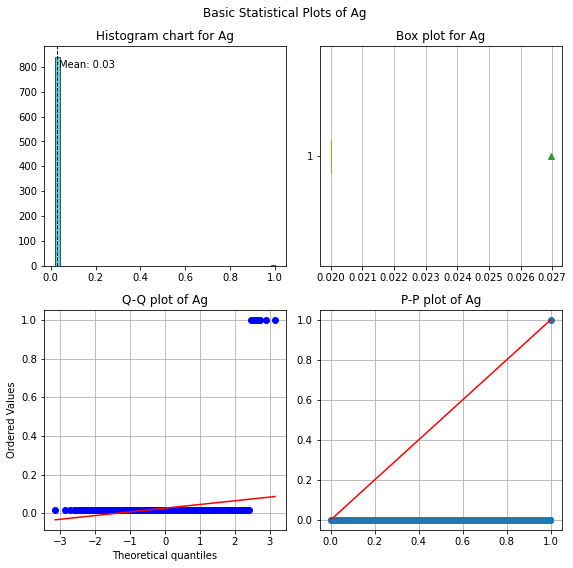

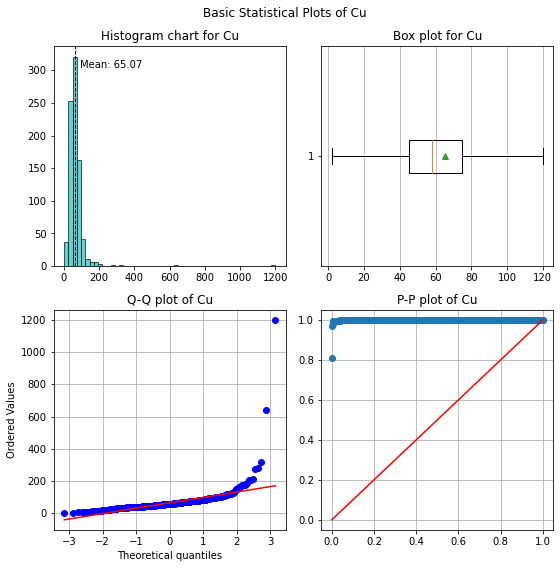

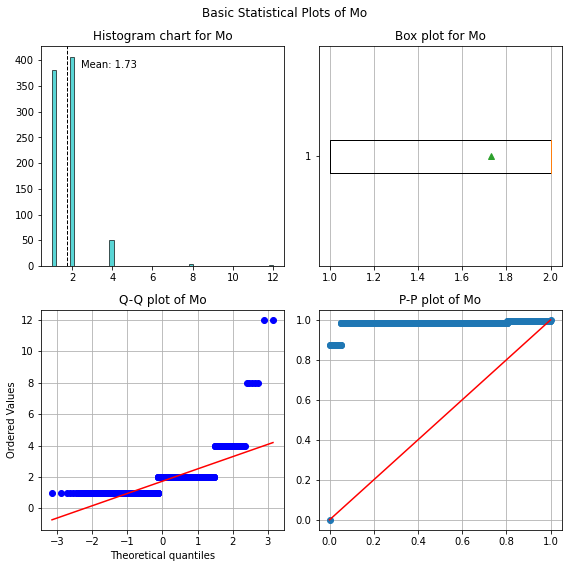

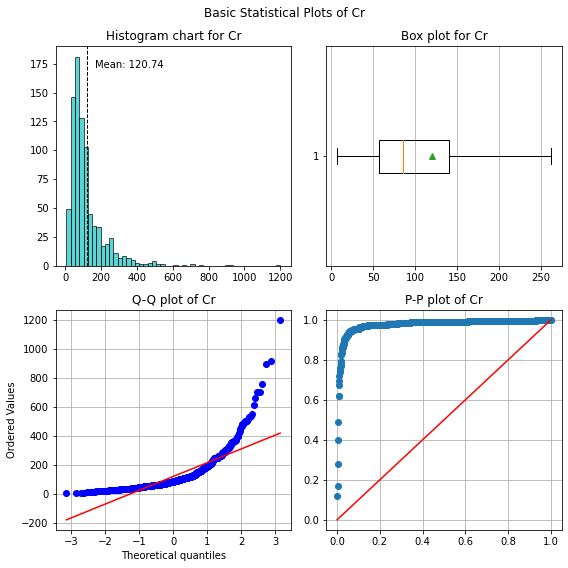

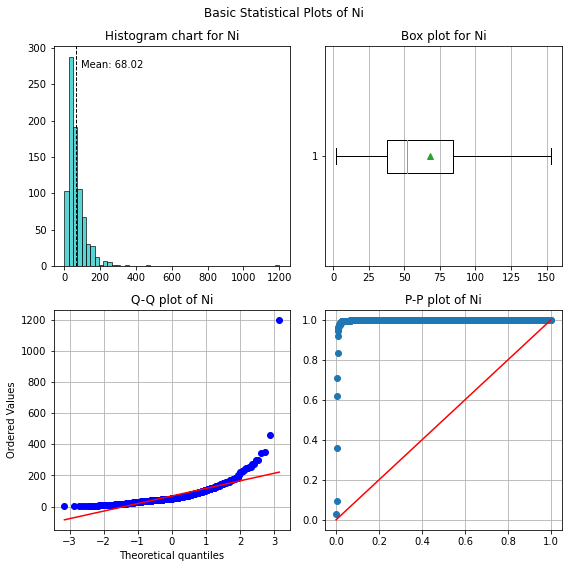

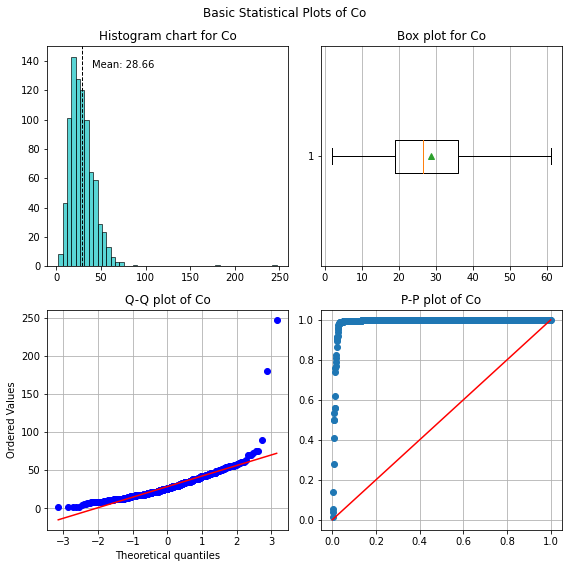

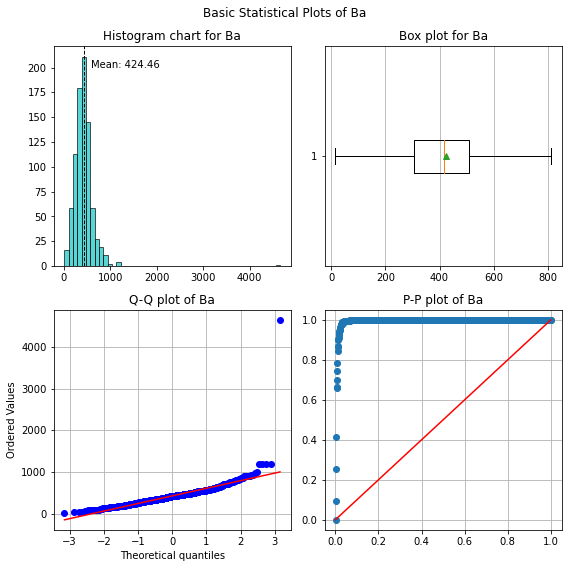

In [47]:
raw_data = preprocess('Data.csv')
elements = input_elements
for column in raw_data.loc[:, elements.split()].columns:
    statistical_plots(column)

## Part 2<a name="Part2"></a>

The purpose of this research is to use a data-driven method to integrate several evidential layers for mineral potential mapping. Layer integration is done by index overlay method. This method is considered knowledge-driven since assigning weights is based on expert judgement. In this research prediction-area diagrams are used to assign weights to evidential layers.

In the following part, gridding, mapping, principal component analysis, concentration-area fractal models, and prediction-area diagrams are programmed. The user needs to only run each cell to study the results.

### Gridding<a name="gridding"></a>

Data visualization helps us to understand the given dataset. Element concentrations in the dataset are in a discritized form. If the current data base is mapped, the final result would be a scatter plot with some 800 points. That is not our goal. We're looking for a smooth image. In order to achieve that, element concentration needs to be interpolated. There are many different types of interpolation. In this research [`griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) function is used from `scipy` library. This  has three different interpolation methods which the user can select; namely `cubic`, `nearest`, and `linear`. It's highly recommended to use the `cubic` method for the smoothest result as the entry for the `interpolation_method` argument of the following `gridding` function. However, for the ease of use, `linear` method is used in this research. Hopefully in the future the two other methods can be used without running into any errors. You can see the difference between the three different methods in the image below:

<img src="https://docs.scipy.org/doc/scipy/_images/scipy-interpolate-griddata-1.png" alt="nearest, linear, and cubic interpolation methods" href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html" width=600px>

It's noteworthy to mention that in the `gridding` function, grid points are stacked along `axis = -1` since X and Y coordiantes needed to be paired with each other.
  

In [56]:
def gridding(raw_data, x_coordinates, y_coordinates, element_concenteration, interpolation_method, feature_range = (0.001, 0.999), fill_value=0):

    column_x = raw_data.loc[:, f'{x_coordinates}'].values
    column_y = raw_data.loc[:, f'{y_coordinates}'].values
    column_z = raw_data.loc[:, f'{element_concenteration}'].values
    scaler = MinMaxScaler(feature_range=feature_range)
    column_zs = scaler.fit_transform(column_z.reshape(-1, 1)).reshape(raw_data.shape[0], )

    x_axis = np.linspace(min(column_x), max(column_x), 1000)
    y_axis = np.linspace(min(column_y), max(column_y), 1000)

    grid_points = np.meshgrid(x_axis, y_axis)
    grid_points = np.stack(grid_points, axis=-1)

    transposed_mat = np.array([column_x, column_y]).T
    grid = griddata(transposed_mat, np.array(column_z), grid_points, method=interpolation_method,
                    fill_value=fill_value)
    grids = griddata(transposed_mat, np.array(column_zs), grid_points, method=interpolation_method,
                     fill_value=fill_value)

    return grid, grids, column_x, column_y, column_z, column_zs


### Mapping<a name="mapping"></a>
There are many different ways to make this visualization graphically understandable. The matplotlib library that helps with plotting, provides the coloring. Here the `seismic` variant is used. However, the user can select the color spectrum of choice from matplotlib library [documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html). It is highly recommended to use `seismic`, `rainbow`, or `terrain` as enteries for the `cmap` argument of the following `mapping` function. 

In [57]:
def mapping(raw_data, element_concenteration, cmap, title):
    
    fig, ax = plt.subplots(3, 3, figsize = (36, 28))
    
    for counter, column in enumerate((raw_data.loc[:, element_concenteration.split()].columns)):
        x_index, y_index = int(counter/3), counter%3
        grid = gridding(raw_data, input_X, input_Y, column, input_interpol)[0]
        plot = ax[x_index, y_index].imshow(grid, origin='lower', cmap=plt.get_cmap(cmap))
        cbar = fig.colorbar(plot, ax = ax[x_index, y_index])
        cbar.set_label('',labelpad=+2)
        ax[x_index, y_index].set_title(f"{title}{column}")

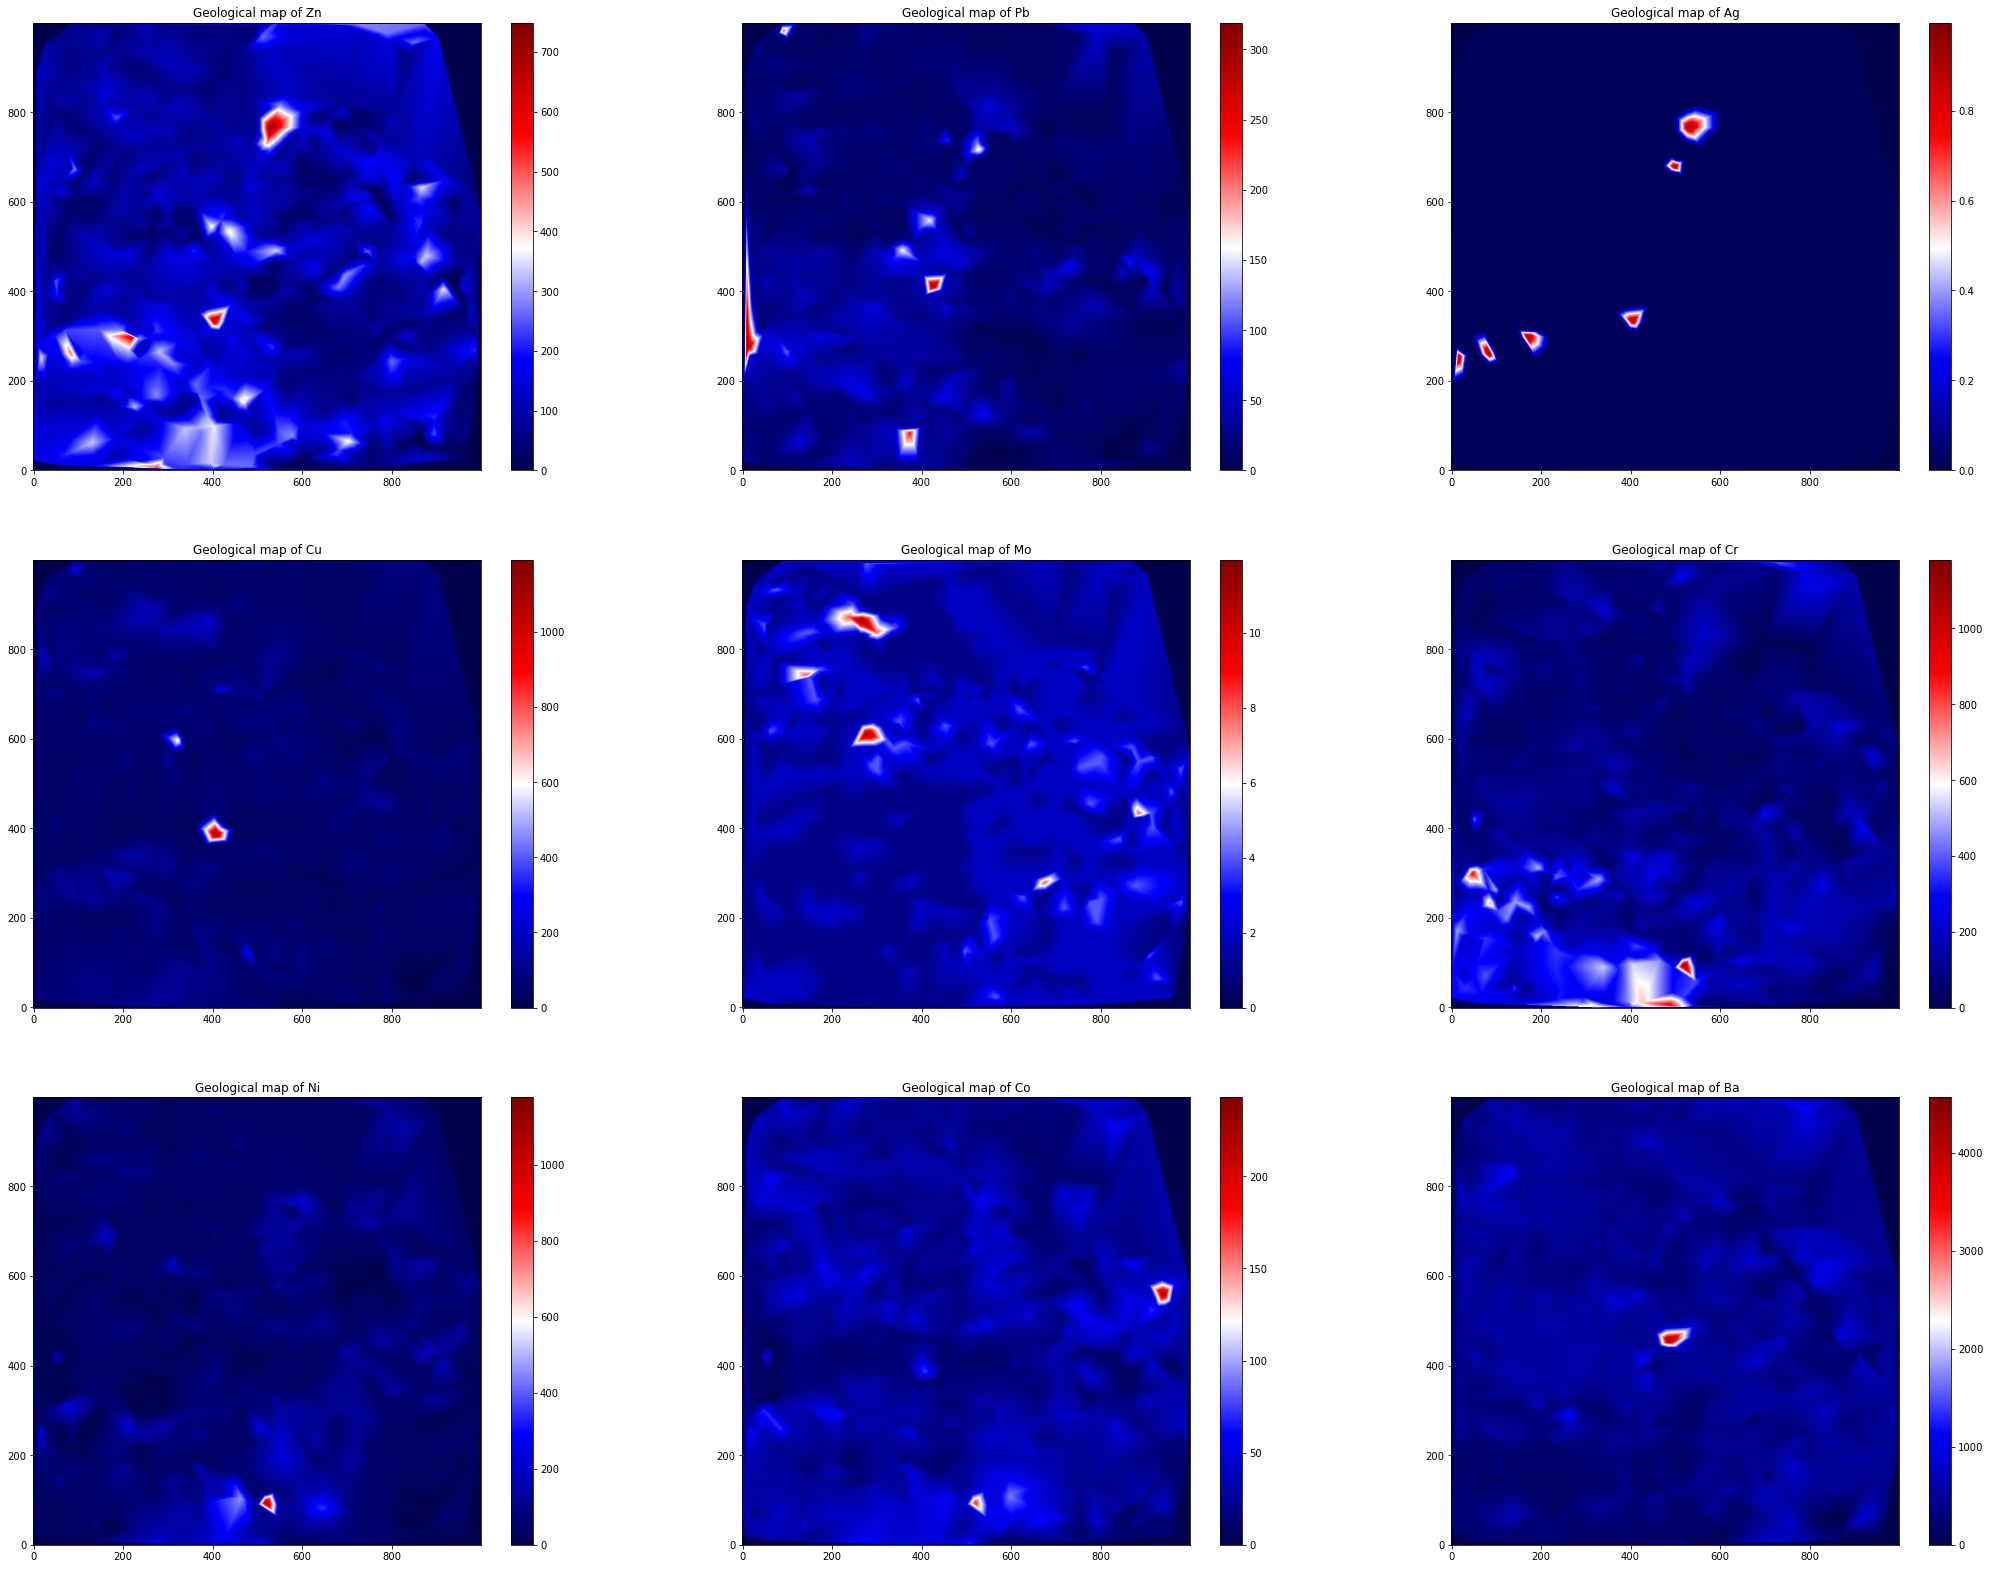

In [58]:
raw_data = preprocess('Data.csv')
mapping(raw_data, input_elements, 'seismic', title="Geological map of ")

### Principal Component Analysis<a name="pca"></a>

[Principal Component Analysis](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) is the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest. Since the importance of this tool is much higher than other statistical tools, it's been decided to assign a different section for it.

There can be infinite PCAs. Here we compute as many PCAs as the number of elements, which is 9 in this case. It's best to standardize the data before computing PCA. This was done in the `gridding` function and we just call it in here. The explained variance for each PCA is also calculated and termed as PCA Matrix.   


In [59]:
def pca(element_concentration):
    
    raw_data = preprocess('Data.csv')
    splitted = element_concentration.split()
    ele = raw_data.loc[:, splitted].values
    ele = StandardScaler().fit_transform(ele)

    column_names_PCA = []
    for i in range(1, len(splitted) + 1):
        column_names_PCA.append(f"PCA{i}")

    pca = PCA(n_components=len(splitted))
    principalComponents = pca.fit_transform(ele)
    loadings1 = pd.DataFrame(np.round(pca.components_.T, 3), columns=column_names_PCA, index=splitted)

    
    column_names_PCA_matrix = []
    for i in range(1, len(splitted) + 1):
        column_names_PCA_matrix.append(f"PCAM{i}")

    loadings2 = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_matrix = pd.DataFrame(np.round(loadings2, 3), columns=column_names_PCA_matrix, index=splitted)

    
    
    processed_df = pd.DataFrame()
    for i,element in enumerate(splitted):
        raw_data[element] = raw_data[element] * max(loadings1.loc[element,:])

    processed_df = processed_df.append(raw_data,False)

    
    return loadings1, processed_df, loadings_matrix


 Here is the Principal Component Analysis for each element:

     PCA1   PCA2   PCA3   PCA4   PCA5   PCA6   PCA7   PCA8   PCA9
Zn  0.437 -0.378 -0.160  0.131 -0.099 -0.166 -0.416  0.510 -0.391
Pb  0.250 -0.502  0.110 -0.351  0.004 -0.483  0.538 -0.065  0.152
Ag  0.217 -0.339 -0.159  0.723 -0.218  0.233  0.211 -0.343  0.162
Cu  0.224 -0.102  0.489  0.185  0.773  0.041 -0.142 -0.192 -0.102
Mo -0.065  0.250  0.579  0.349 -0.394 -0.552 -0.127 -0.018  0.012
Cr  0.480  0.168 -0.203 -0.228 -0.058 -0.160 -0.495 -0.411  0.453
Ni  0.456  0.391  0.004 -0.125 -0.165  0.094  0.298 -0.311 -0.634
Co  0.455  0.324  0.213  0.053 -0.007  0.282  0.282  0.549  0.424
Ba  0.007 -0.362  0.526 -0.333 -0.399  0.514 -0.212 -0.116 -0.011

 And, here is the Principal Component Analysis Matrix of each element:

    PCAM1  PCAM2  PCAM3  PCAM4  PCAM5  PCAM6  PCAM7  PCAM8  PCAM9
Zn  0.673 -0.451 -0.175  0.131 -0.092 -0.147 -0.313  0.335 -0.242
Pb  0.386 -0.598  0.120 -0.352  0.004 -0.427  0.404 -0.043  0.094
Ag  0.33

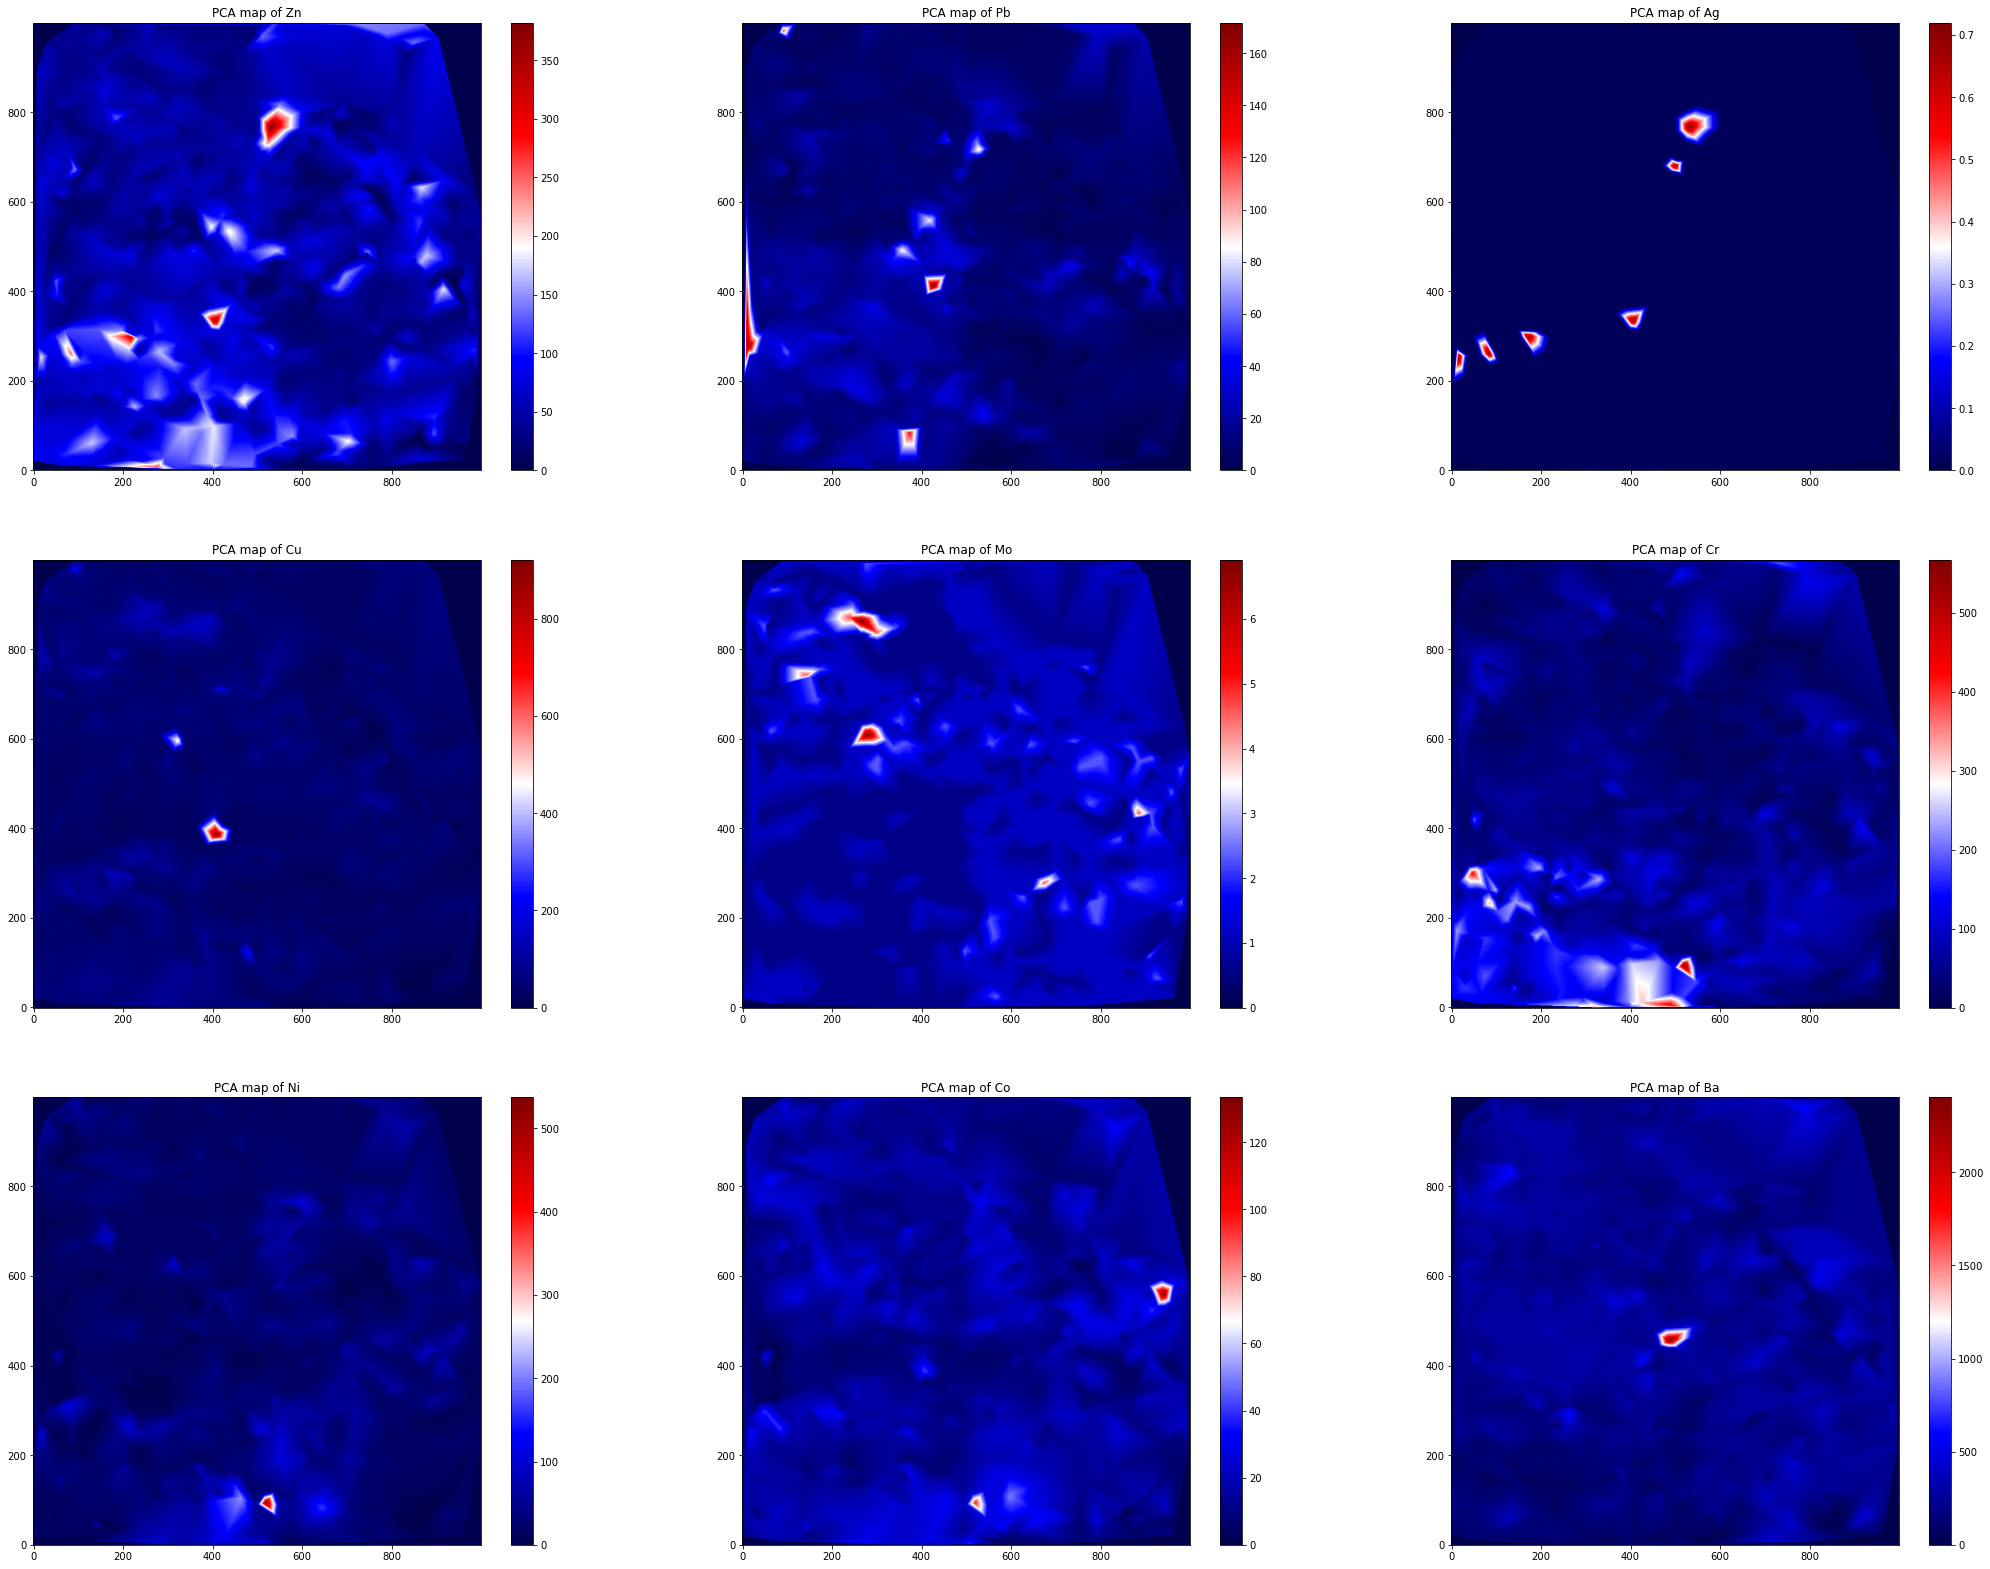

In [60]:
a, b, c = pca(input_elements)

print(" Here is the Principal Component Analysis for each element:\n")
print(a)
print("\n And, here is the Principal Component Analysis Matrix of each element:\n")
print(c)
print("\n Finally, here is the PCA map of each element:\n")

mapping(b, input_elements, 'seismic', title="PCA map of ")

### Concenteration-Area (C-A) Fractal Modelling<a name="ca"></a>

In order to determine a data-driven threshold for different classes of an evidential layer, we can use concetration-area fractal modding to achieve this.

According to the literature<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), this logarithmic diagram consists of two axes. The values on the vertical axis corresponds with the logarithm of the area of the map. The horizontal axis correponds with the logarithmic values of the concentration of an element. Thus, each point in this diagram represents the area occupied within a specific threshold of concenteration; lower the concenteration, i.e. closer to zero, bigger the area occupied within that threshold.   

As said before, in order to determin thresholds for the classes of the evidential layer, the C-A diagram is used. To draw this diagram the evidential map is divided into equal slices. Each slice holds the area within a specific range of concenteration values; e.g. the range of concenteration between 0.1 to 0.2 holds 20 percent of the area. In this research, the range of element concenteration is divided into `24` equal parts. Then the area within each slice is calculated.   

After plotting each datapoint into the diagram, some lines are fitted into these `24` points. The number of lines that fit these datapoints can vary. Here `5` lines are fitted. Least Squares method is used to fit the lines into the data points.

In [62]:
def best_fit(X, Y):
      
    n = len(X) 
    xbar = sum(X)/n

    m = len(Y)
    ybar = sum(Y)/m    

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2
    b = numer / denum
    a = ybar - b * xbar

    return a, b

In [72]:
def get_area(element_concenteration, raw_data, num_slice, interpolation_method):
    
    grid1,_,col_x, col_y, _, col_z,=gridding(raw_data, input_X, input_Y, element_concenteration, interpolation_method = input_interpol, fill_value=0.1)

    thr = round((max(col_z)-min(col_z))/num_slice, 2)
    slices = [np.min(grid1)] + [np.min(grid1)+ i*thr for i in range(1,num_slice)] + [np.max(grid1)]
    real_area = (max(col_x)-min(col_x))*(max(col_y)-min(col_y))
    
    areas = []
    X_values = []

    for i, value in enumerate(slices):
        try:


            if i != 0:
                helper = np.where((grid1 < slices[i+1])&(grid1>=value))
                sub_area = helper[0].shape[0]
                sub_area = round(sub_area*real_area/1000000,2)
                if np.mean(grid1[helper[0], helper[1]]) > 0.1:
                    if sub_area > areas[-1]:
                        del areas[-1]
                        X_values.append(np.mean(grid1[helper[0], helper[1]]))
                        areas.append(sub_area)
                    else:
                        X_values.append(np.mean(grid1[helper[0], helper[1]]))
                        areas.append(sub_area)

            else:
                helper = np.where(grid1 < slices[i+1])
                sub_area = helper[0].shape[0]
                sub_area = round(sub_area*real_area/1000000,2)
                X_values.append(np.mean(grid1[helper[0], helper[1]]))
                areas.append(sub_area)


        except:
            ar = []
            xv = []
            for i in range(len(areas)):
                if X_values[i] > 0.1:
                    ar.append(areas[i])
                    xv.append(X_values[i])
            return ar[-20:], xv[-20:]



In [73]:
def ca(data, elements):
    
    fig, ax = plt.subplots(3, 3, figsize = (36, 28))
    
    points = {}
    lines = {}

    for counter, column in enumerate(data.loc[:, elements.split()].columns):

        lines[column] = []
        scaler = MinMaxScaler(feature_range=(0.01,0.99))
        m = max(data[column])
        data[column] = scaler.fit_transform(data[column].values.reshape(-1,1)).reshape(data.shape[0],)
        areas, X_values = get_area(column,data, 24, 'linear')
        X = []
        Y = []
        for i, area in enumerate(areas):
            X.append(np.log10(X_values[i]))
            Y.append(np.log10(area))
  

        points[column] = [np.array_split(np.array(X), 5), np.array_split(np.array(Y), 5)]
    
        for i in range(5):
            x = list(points[column][0][i])
            y = list(points[column][1][i])
            a,b = best_fit(x, y)
            lines[column] += [[a,b]]
      
            if i != 0:
                x = list(points[column][0][i-1])[:] + x

            try:
                x =  x + list(points[column][0][i+1])[:]
            except:
                pass

            y = [a + b*xi for xi in x]
            ax[int(counter/3), counter%3].plot(x, y, 'r')
        ax[int(counter/3), counter%3].scatter(X, Y)
        ax[int(counter/3), counter%3].set_title(f"C-A diagram of {column}")
        ax[int(counter/3), counter%3].set_xlabel(f"Log transformed value of {column}")
        ax[int(counter/3), counter%3].set_ylabel(f"Log(Area) of {column}")
        ax[int(counter/3), counter%3].grid()
        
    return lines

The rest of the program works based on a `lines` variable that is calculated using `ca` function. So, the values of this variable is returned to the user and is stored in `lines_from_ca` variable.

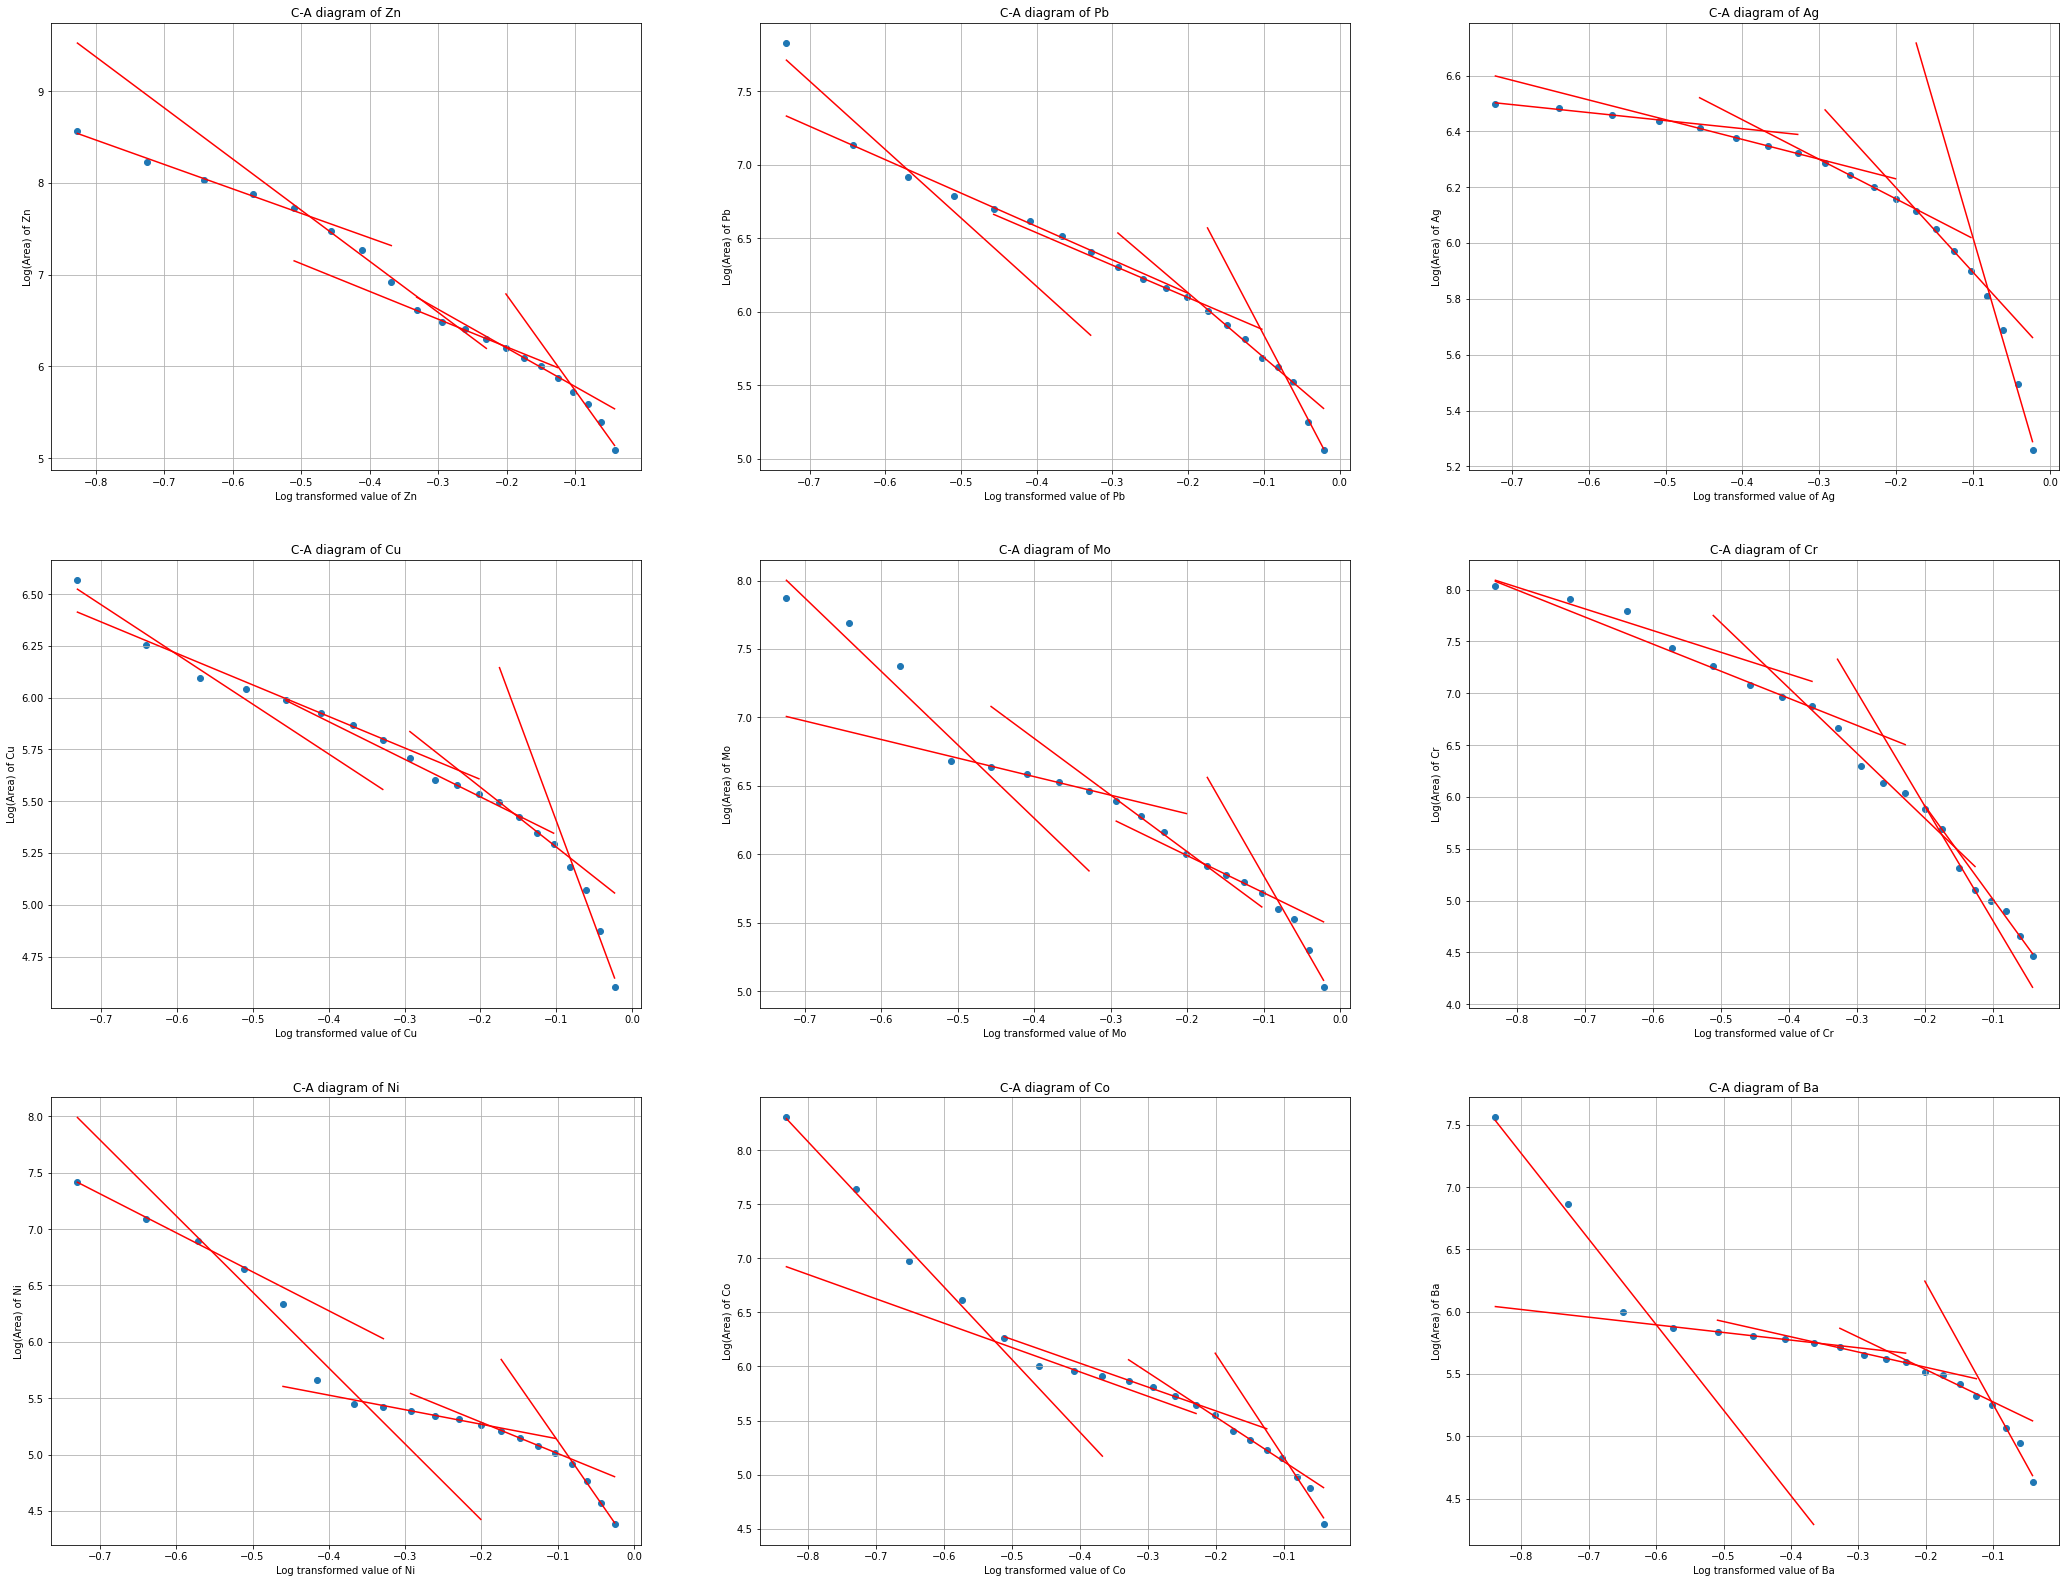

In [90]:
raw_data = preprocess('Data.csv')
lines_from_ca = ca(raw_data, input_elements)

### Determining Threseholds for Classes of an Evidential Map<a name="discrete"></a>

After drawing the diagram, there's only one step left towards finding thresholds for each class of the evidential layer. The linear lines drawn in each diagram has intercetion points. The value of these intersection points on the horizontal axis of the fractal model, i.e. logarithmic values of element concenteration, is calculated. Since these values are logarithmic, the inverse logarithm of these values are computed. Now, these values can be used as threshold ranges for each class of the evidential map. A new discretized evidential map is drawn based on these new thresholds.   

The location of known mineral occurences in the area is very important as prediction-area diagrams are drawn based on them. So, in this step a file containing this data is imported and processed in `known_minerals` function. The file contains coordinates and names of these occurences. They are scatter-plotted in the new discretized evidential map.

In [75]:
def known_minerals(element_concenteration, raw_data, interpolation_method):
    
    # the file path to the file containing known mineral occurences
    # can be given instead of this default path
    file_path = pd.read_excel('Known_mineral_deposits-970729.xls')[['XUTM', 'YUTM']]
    
    _,_,col_x2, col_y2, _,_=gridding(raw_data, input_X, input_Y, element_concenteration , interpolation_method = input_interpol, fill_value=0.1)
    
    known_mineral_x = []
    known_mineral_y = []
    for index, row in file_path.iterrows():
        x = int(row['XUTM'])
        x = int((x - min(col_x2)) * (1000) / (max(col_x2) - min(col_x2)))

        y = int(row['YUTM'])
        y = int((y - min(col_y2)) * (1000) / (max(col_y2) - min(col_y2)))

        known_mineral_x.append(x)
        known_mineral_y.append(y)
        
    return known_mineral_x, known_mineral_y

In [76]:
def discrete_mapping(element_concenteration, raw_data, interpolation_method, slices, ax, counter, fig):

    grid2 = gridding(raw_data, input_X, input_Y, element_concenteration, interpolation_method)[0]
    
    cmap = mpl.colors.ListedColormap(['green', 'cyan', 'yellow', 'orange','blue', 'linen','saddlebrown','salmon','darkkhaki'][:len(slices)-1])
    bounds = slices
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    known_mineral_x, known_mineral_y = known_minerals(element_concenteration, raw_data, interpolation_method)
    

    ax[int(counter/3), counter%3].imshow(grid2,  origin='lower', cmap=cmap)
    ax[int(counter/3), counter%3].scatter(known_mineral_x, known_mineral_y, c = 'black', marker = '^')
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),extendfrac='auto',ticks=bounds,spacing='uniform', ax = ax[int(counter/3), counter%3])
    cbar.set_label('',labelpad=+2)
    ax[int(counter/3), counter%3].set_title(f"Discretized map of {element_concenteration}")

In [77]:
def discrete_mapping_iterated(raw_data,element_concenteration,lines):
    
    fig, ax = plt.subplots(3, 3, figsize = (36, 28))
    
    for counter, column in enumerate((raw_data.loc[:, element_concenteration.split()].columns)):
        
        raw_data[column] = gridding(raw_data, input_X, input_Y, column, input_interpol, feature_range=(0.1, .99))[4]
        slices = [0.1]
        for i,line in enumerate(lines[column]):
            try:
                a = np.array([[-1*line[1],1], [-1*lines[column][i+1][1],1]])
                b = np.array([line[0],lines[column][i+1][0]])
                x = np.linalg.solve(a, b)
                if 10 ** x[0] > slices[-1] and 10 ** x[0] >= 0.1 and 10 ** x[0] <= 1.1:
                    slices.append(10 ** x[0])
            except:
                pass
            
        #print(f"Intersection points of {column} : {slices[1:]}")
        slices.append(1.1)
        discrete_mapping(column, raw_data, input_interpol, slices, ax, counter, fig)


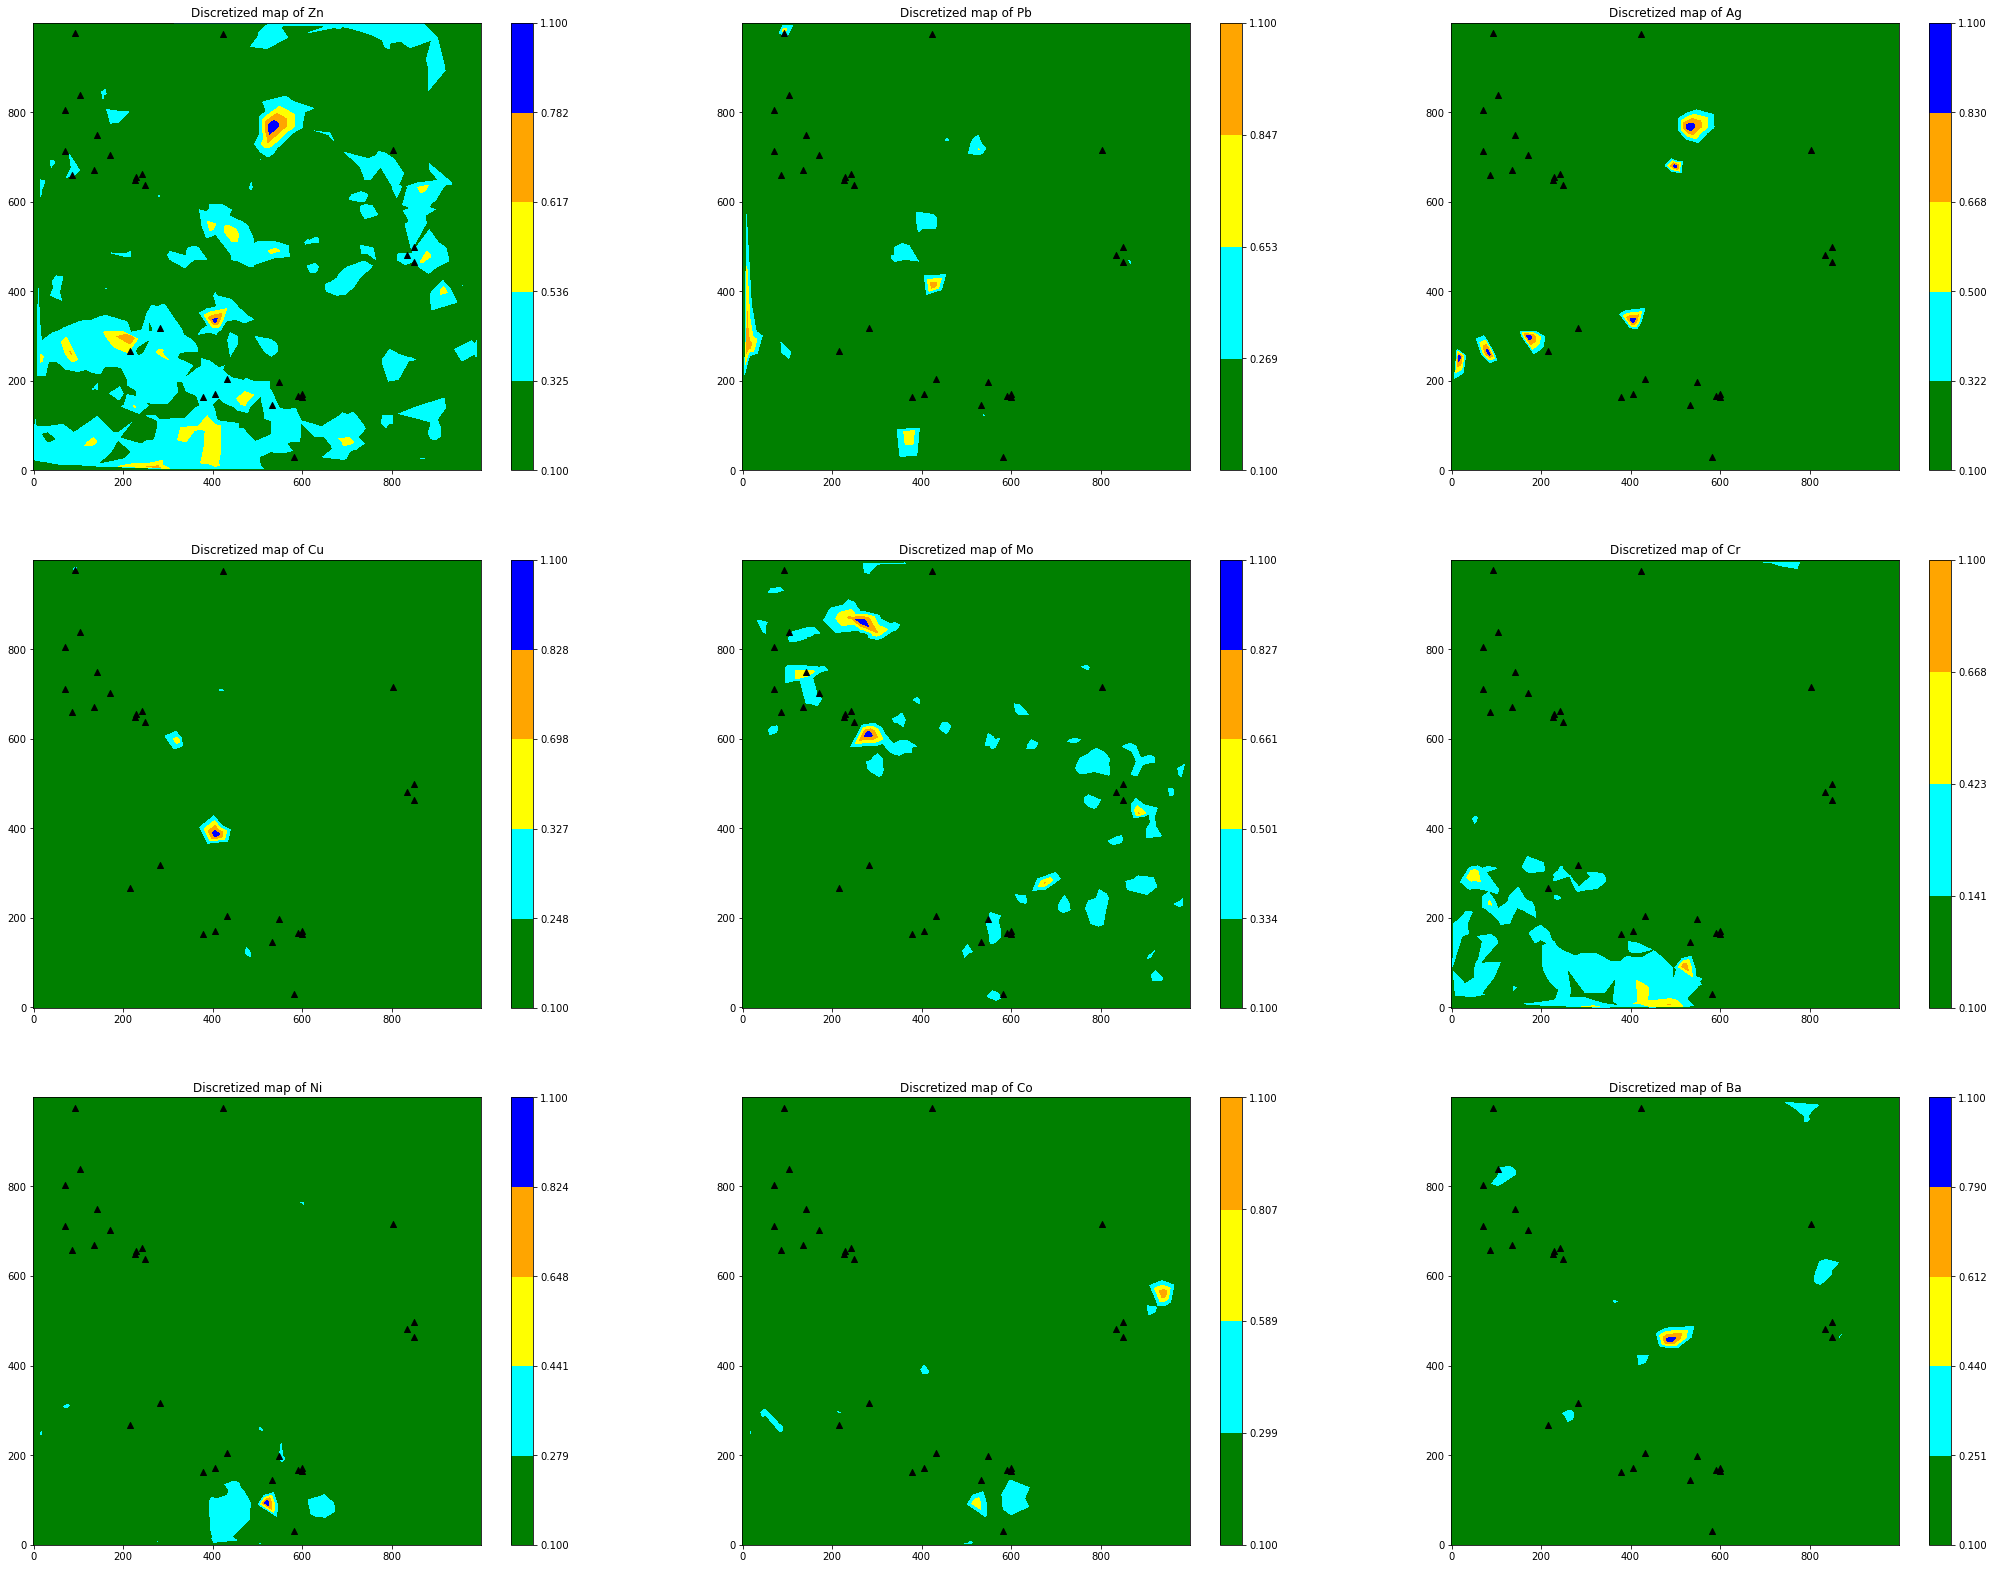

In [78]:
discrete_mapping_iterated (raw_data,input_elements,lines=lines_from_ca)

### Prediction-Area (P-A) Diagrams <a name="pa"></a>

The ultimate goal of this research is assigning weights to different classes of evidence of an evidential map in a data-driven way. As mentioned in the introduction, in order to do so, prediction-area (P-A) plots have been used. All of previous processes were coded to make drawing P-A diagrams possible.   

This diagram actually consists of two diagrams which are overlaid on top of each other. One diagram is percentage of known mineral occurences in an evidential map to values of element concenteration in the same map. The other diagram is the percentage of study area for each class of evidential map to values of element concenteration. When overlaid, there's a single diagram that has three axes; the left vertical axis correponds with the percentage of known mineral occurences, the right vertical axis corresponds with the percentage of study area, and finally the horizontal axis gives us element concenteration.   

As these two diagrams are overlaid, there is an intersection point. Features of this intersection point is used to  determine the weight of each evidential map.

In [79]:
def area_percentage(element_concenteration, raw_data, interpolation_method, slices):

    grid1, _, col_x, col_y, col_z, _ = gridding(raw_data, input_X, input_Y, element_concenteration , interpolation_method = input_interpol, fill_value=0.1)
    known_mineral_x, known_mineral_y = known_minerals(element_concenteration, raw_data, interpolation_method)
    

    known_mineral_percent = []
    for i, value in enumerate(slices):
        try:
            if i==0:
                helper = np.where(grid1[known_mineral_x, known_mineral_y] < slices[i+1])
                p = round(helper[0].shape[0]*100/len(known_mineral_x), 4)
                known_mineral_percent.append(p)
            else:
                helper = np.where((grid1[known_mineral_x, known_mineral_y] < slices[i+1])&(grid1[known_mineral_x, known_mineral_y]>=value))
                p = round(helper[0].shape[0]*100/len(known_mineral_x), 4)
                known_mineral_percent.append(p)
        except:
            break
    percents = []
    for i, value in enumerate(slices):
        try:
            if i==0:
                helper = np.where(grid1 < slices[i+1])
                p = round(helper[0].shape[0]*100/1000000, 2)
                percents.append(p)
            else:
                helper = np.where((grid1 < slices[i+1])&(grid1>=value))
                p = round(helper[0].shape[0]*100/1000000, 2)
                percents.append(p)
        except:
            return percents, known_mineral_percent, slices


In [80]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [81]:
def pa_diagram (raw_data, element_concenteration, lines):
    
    fig, ax = plt.subplots(3, 3, figsize = (36, 28))
    intersections = {}
            
    for counter, column in enumerate(raw_data.loc[:, element_concenteration.split()].columns):
        
        scaler = MinMaxScaler(feature_range=(0.01,0.99))
        m = max(raw_data[column])
        raw_data[column] = scaler.fit_transform(raw_data[column].values.reshape(-1,1)).reshape(raw_data.shape[0],)
        
        slices = [0.1]
        
        for i,line in enumerate(lines[column]):
            try:
                a = np.array([[-1*line[1],1], [-1*lines[column][i+1][1],1]])
                b = np.array([line[0],lines[column][i+1][0]])
                x = np.linalg.solve(a, b)
                if 10 ** x[0] > slices[-1] and 10 ** x[0] >= 0.2:
                    slices.append(10 ** x[0])
            except:
                pass
        slices.append(0.99)
    
        percents, known_mineral_percent, slices = area_percentage(column, raw_data, input_interpol, slices)

        known_mineral_percent = [a for a in known_mineral_percent if a != 0] + [0]

        xnew = np.arange(slices[1], slices[-1], 0.1)
        
        f1 = interpolate.interp1d(slices[1:], percents, kind = 'slinear')
        f2 = interpolate.interp1d(slices[1:][:len(known_mineral_percent)-1] + [slices[-1]], known_mineral_percent, kind = 'slinear')

        known_mineral_percent = f2(xnew)
        percents = f1(xnew)

        x_new = np.arange(slices[1], slices[-1],0.0001)
        y1_new = f1(x_new)
    
        y2_new = f2(x_new)
        y2_new = np.array([50-(i-50) if i>50 else 50+(50-i) for i in y2_new])
 
        y_new = y1_new-y2_new

        m = min(y_new[list(np.where(y_new>0)[0])])
        point = np.where(y_new==m)[0][0]

        intersections[column] = f"{round(y1_new[point] / (100-y1_new[point]), 2)},{100-y1_new[point]}"

        ax[int(counter/3), counter%3].plot(xnew, known_mineral_percent, c='red')
        ax[int(counter/3), counter%3].set_xlabel('Transformed value of the Element')
        ax[int(counter/3), counter%3].set_ylabel('Percentage of known occurrences(%)')

        ax2 = ax[int(counter/3), counter%3].twinx()
        ax2.plot(xnew, percents, c='green')
        ax2.set_ylabel('Percentage of study area(%)')
        ax2.invert_yaxis()
    
        ax2.grid()
        ax2.set_title(column)
        
    
    intersections.values()
    intersections.keys()

    
    index_names = list(intersections.keys())
    df = pd.DataFrame(index=index_names)
    df['Prediction Rate (%)'] = list(map(lambda a: int(a.split(',')[1][:2]), list(intersections.values())))
    df['Occupied Area (%)'] = [100-i for i in df['Prediction Rate (%)'].values]
    df['Normalized Density'] = [round(i/(100-i), 2) for i in df['Prediction Rate (%)'].values]
    df['Weight'] = [log(i) for i in df['Normalized Density'].values]

    return df

    Prediction Rate (%)  Occupied Area (%)  Normalized Density    Weight
Zn                   50                 50                1.00  0.000000
Pb                   50                 50                1.00  0.000000
Ag                   78                 22                3.55  1.266948
Cu                   90                 10                9.00  2.197225
Mo                   79                 21                3.76  1.324419
Cr                   69                 31                2.23  0.802002
Ni                   81                 19                4.26  1.449269
Co                   70                 30                2.33  0.845868
Ba                   79                 21                3.76  1.324419


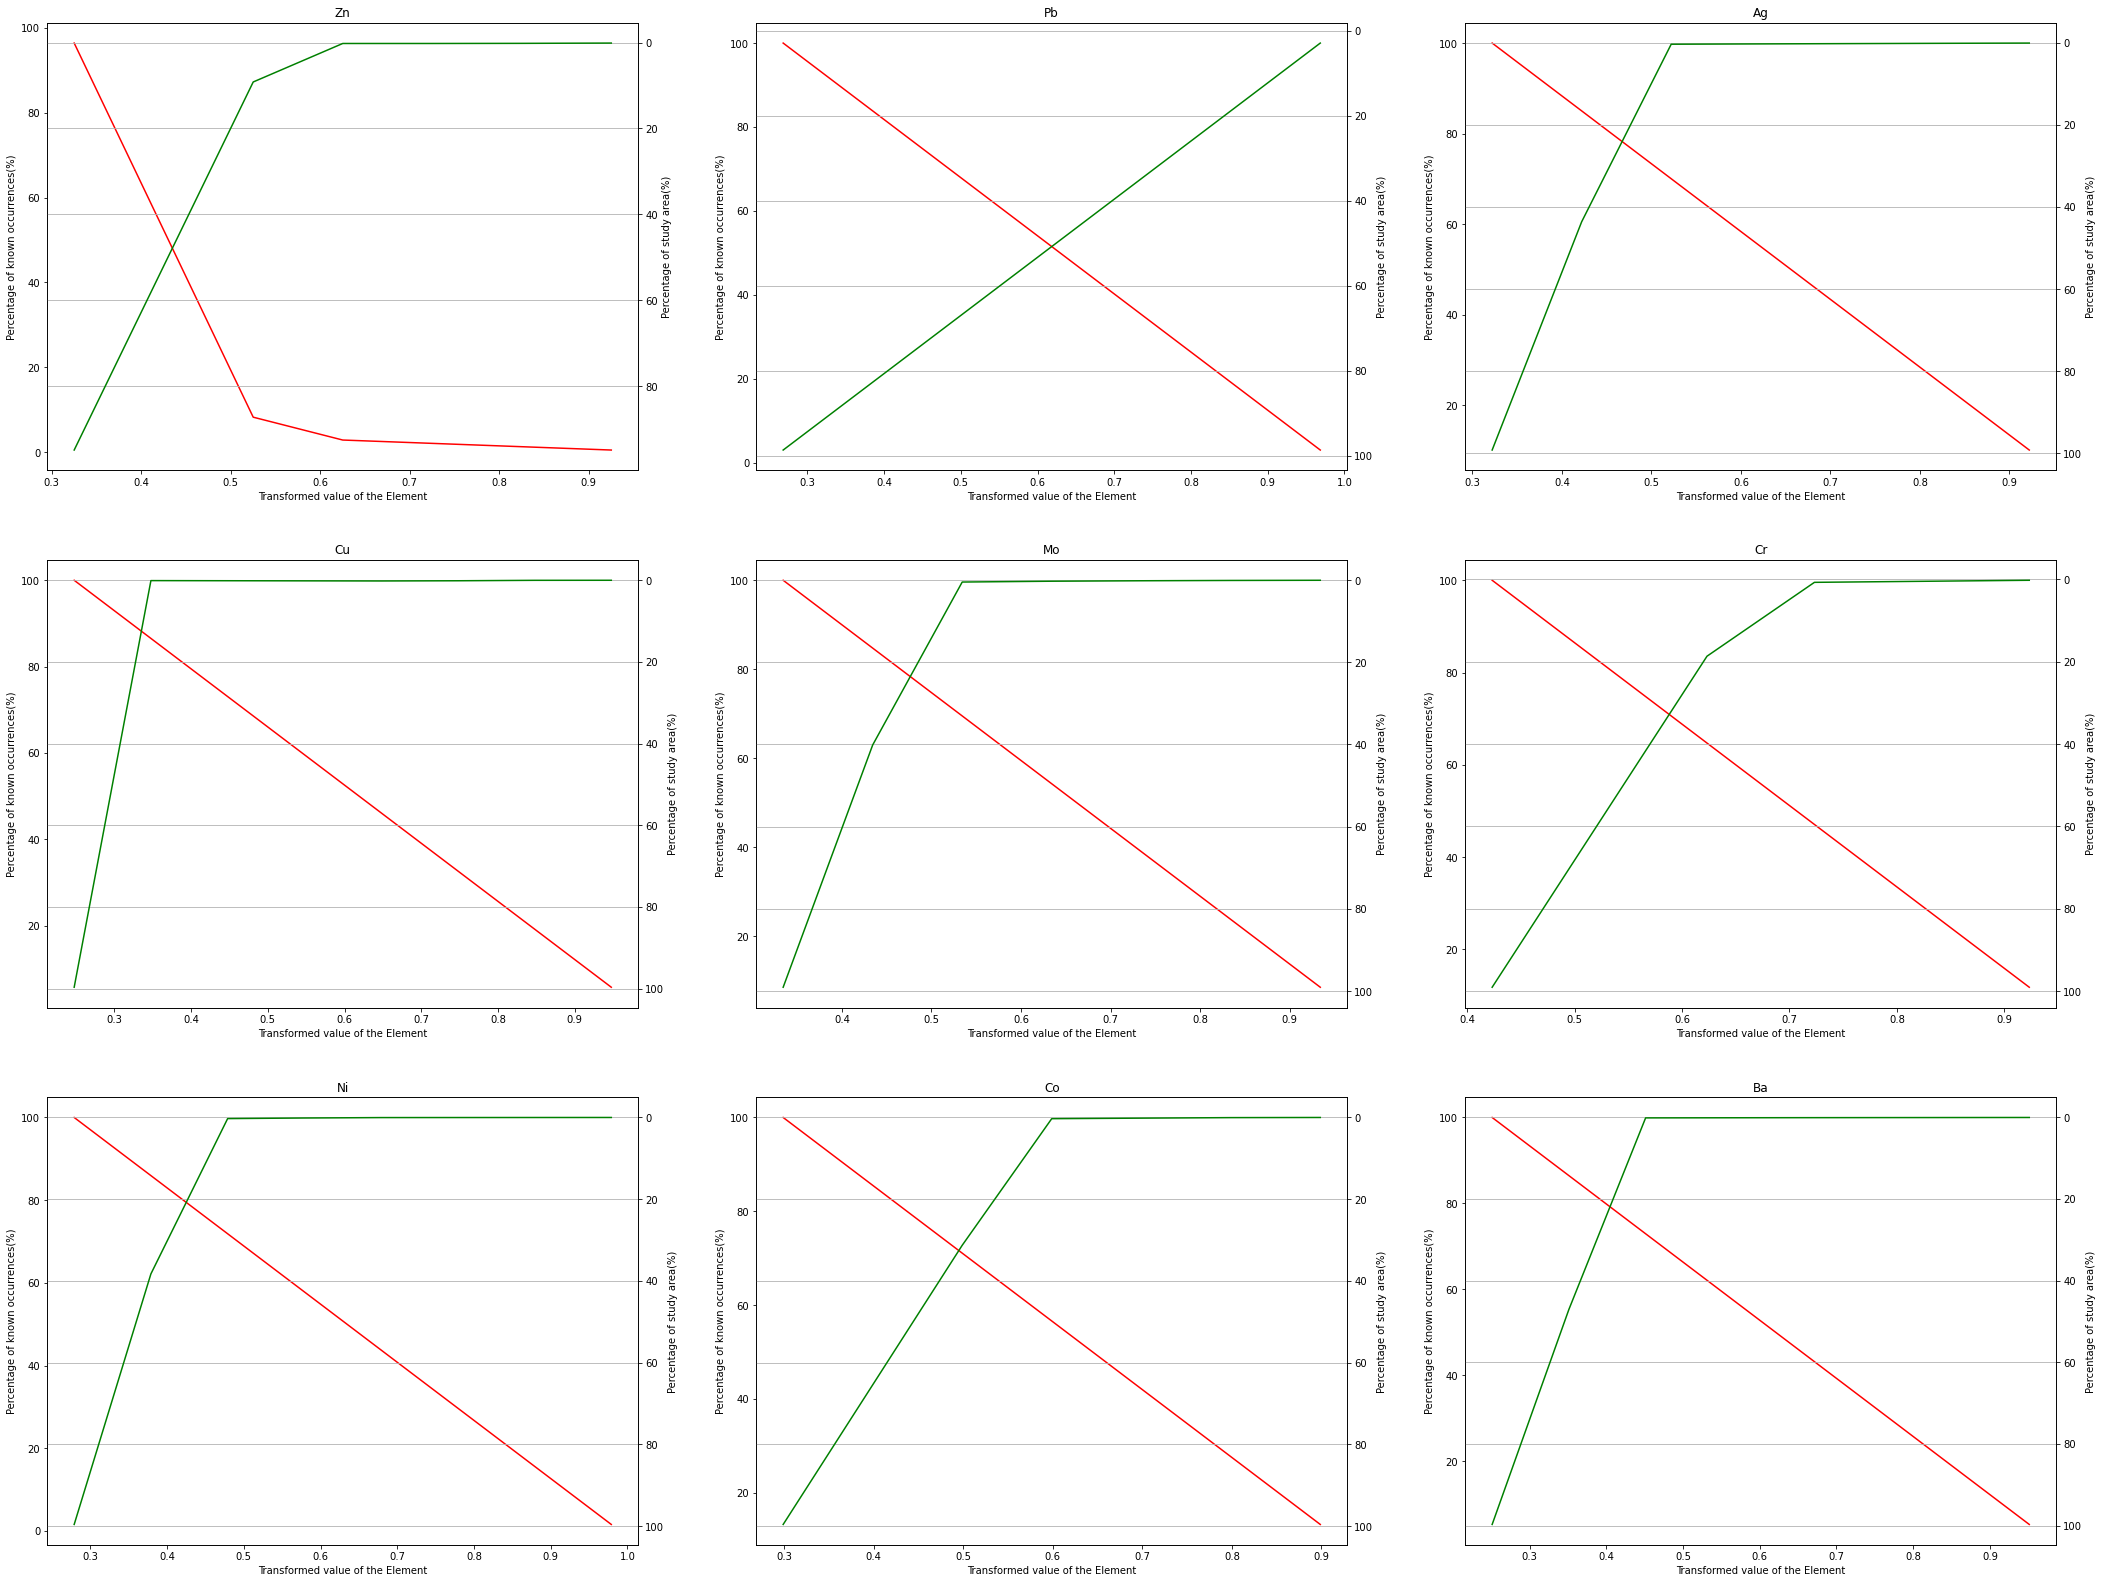

In [82]:
weights = pa_diagram (raw_data,input_elements, lines=lines_from_ca)
print (weights)

### Integrating Evidential Layers <a name="io"></a>

Multiclass index overlay is the method of choice for integrating evidential layers in here. In this method, weights of each evidential layer is assigned subjectively by expert judgement. Each *j*th of the *i*th evidential map is assigned a score, $S_{ij}$, according to their relative importance. This relative importance is controlled using weights, $W_{i}$. Weighted evidential maps are then combined using the following equation.

$$ \overline{S} = \frac{\sum{i}^{n} S_{ij}W_{i}}{\sum{i}^{n} W_{i}}$$

Since weights are assigned based on *expert* judgement, this method is a knowledge-driven method. However, in this research assigning weights is based on the `weights` variable plotted above, extracted from the prediction-area plots, it is considered to be a data-driven index overlay. The data-driven multiclass index overlay is calculated based on the following equation.

$$OM_{IO} = \frac{\sum{i}^{n} T_{vi}W_{Ei}}{\sum{i}^{n} W_{Ei}}$$

In the above equation, for every pixel of the study area, $OM_{IO}$ is the data-driven multiclass index overlay score, $T_{vi}$ is pixel value in evidential map $i$, and $W_{Ei}$ is the weight of evidential map $i$. For the current research, this equation has been written as the following.

$$OM_{IO} = \frac{TV_{Zn}W_{Zn} + TV_{Pb}W_{Pb} + TV_{Ag}W_{Ag} + TV_{Cu}W_{Cu} + TV_{Mo}W_{Mo} + TV_{Cr}W_{Cr} + TV_{Ni}W_{Ni} + TV_{Co}W_{Co} + TV_{Ba}W_{Ba}}{W_{Zn} + W_{Pb} + W_{Ag} + W_{Cu} + W_{Mo} + W_{Cr} + W_{Ni} + W_{Co} + W_{Ba}}$$

The following function is programmed to calculate the final amount of this integration, $OM_{IO}$, and return it alongside the correspoding cartesian coordinates of each data point.

In [92]:
def index_overlay (element_concentration):
    
    # desired elemets in a list
    elements = element_concentration.split()
    # X and Y coordinates of the main data
    coordinates = [input_X,input_Y]
    
    
    # a dataframe copied from the main data
    new_df = raw_data.copy()
    # multiplying concentration values of each element by their respective weight
    new_df.update(new_df[weights.index].mul(weights['Weight']))
    
    
    # sum of all weights from 'pa_diagram'
    weights_sum=weights['Weight'].sum()
    
    
    # creating a new single column dataframe
    final_df=pd.DataFrame()
    # summing each row and deviding it by sum of weights
    final_df['Index Overlay']=new_df[elements].sum(axis=1)/weights_sum
    
    
    # making a list of dataframes to concatenate
    frames = [new_df.loc[:,coordinates],final_df]
    # concatenating the two dataframes
    result = pd.concat(frames,axis=1)
    
    return result

In [93]:
io_data = index_overlay(input_elements)
print(io_data)

             X           Y  Index Overlay
0    431434.79  3305001.94       0.054729
1    432522.60  3298058.43       0.056695
2    438045.35  3291987.05       0.058969
3    436260.76  3294412.90       0.037946
4    439294.48  3297653.81       0.043841
..         ...         ...            ...
841  414614.38  3300475.33       0.072603
842  413559.89  3299053.77       0.054952
843  423054.28  3292767.47       0.063064
844  424400.10  3293090.75       0.075605
845  422508.91  3293635.51       0.085235

[846 rows x 3 columns]


### Model Evaluation <a name="eval"></a>

In order to evaluate this model, this model goes through the exact same processes as the previous evidential layers to examin the predictibility of this model.

In [88]:
def io_mapping(data):
    
    # fetching the data using the gridding function
    io_grid = gridding(data, 'X', 'Y', 'Index Overlay', input_interpol)[1]
    
    # mapping
    plt.imshow(io_grid, origin='lower',cmap=plt.get_cmap('seismic'))
    cbar = plt.colorbar()
    plt.gcf().set_size_inches(7, 7)
    plt.title("Map of objective multiclass index overlay socres")
    plt.show()

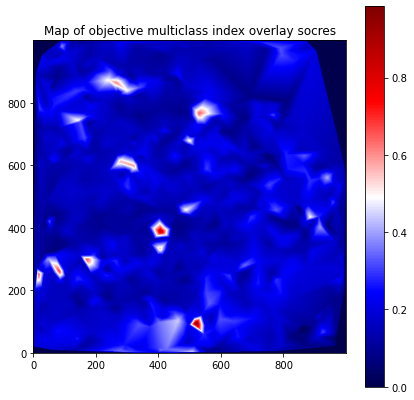

In [107]:
io_mapping(io_data)

In [108]:
def get_area_modified(raw_data, num_slice, interpolation_method):
    
    grid1,_,col_x, col_y, _, col_z,=gridding(raw_data, 'X', 'Y', 'Index Overlay', input_interpol)

    thr = round((max(col_z)-min(col_z))/num_slice, 2)
    slices = [np.min(grid1)] + [np.min(grid1)+ i*thr for i in range(1,num_slice)] + [np.max(grid1)]
    real_area = (max(col_x)-min(col_x))*(max(col_y)-min(col_y))
    
    areas = []
    X_values = []

    for i, value in enumerate(slices):
        try:


            if i != 0:
                helper = np.where((grid1 < slices[i+1])&(grid1>=value))
                sub_area = helper[0].shape[0]
                sub_area = round(sub_area*real_area/1000000,2)
                if np.mean(grid1[helper[0], helper[1]]) > 0.1:
                    if sub_area > areas[-1]:
                        del areas[-1]
                        X_values.append(np.mean(grid1[helper[0], helper[1]]))
                        areas.append(sub_area)
                    else:
                        X_values.append(np.mean(grid1[helper[0], helper[1]]))
                        areas.append(sub_area)

            else:
                helper = np.where(grid1 < slices[i+1])
                sub_area = helper[0].shape[0]
                sub_area = round(sub_area*real_area/1000000,2)
                X_values.append(np.mean(grid1[helper[0], helper[1]]))
                areas.append(sub_area)


        except:
            ar = []
            xv = []
            for i in range(len(areas)):
                if X_values[i] > 0.1:
                    ar.append(areas[i])
                    xv.append(X_values[i])
            return ar[-20:], xv[-20:]



In [125]:
def ca_modified(data, elements):
    
    
    points = []
    lines = []

    scaler = MinMaxScaler(feature_range=(0.01,0.99))
    m = max(data['Index Overlay'])
    data['Index Overlay'] = scaler.fit_transform(data['Index Overlay'].values.reshape(-1,1)).reshape(data.shape[0],)
    areas, X_values = get_area_modified(data, 24, 'linear')
    X = []
    Y = []
    for i, area in enumerate(areas):
        X.append(np.log10(X_values[i]))
        Y.append(np.log10(area))
  

    points = [np.array_split(np.array(X), 5), np.array_split(np.array(Y), 5)]
    
    for i in range(5):
        x = list(points[0][i])
        y = list(points[1][i])
        a,b = best_fit(x, y)
        lines += [[a,b]]
      
        if i != 0:
            x = list(points[0][i-1])[:] + x

        try:
            x =  x + list(points[0][i+1])[:]
        except:
            pass

        y = [a + b*xi for xi in x]
        plt.plot(x, y, 'r')
    plt.scatter(X, Y)
    plt.title(f"C-A diagram of {'Index Overlay'}")
    plt.xlabel(f"Log transformed value of {'Index Overlay'}")
    plt.ylabel(f"Log(Area) of {'Index Overlay'}")
    plt.grid()
        
    return lines

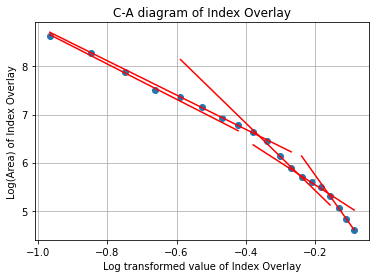

In [126]:
new_lines_from_ca = ca_modified(io_data, input_elements)

## References <a name="refer"></a>

<a name="cite_note-1"></a> 1. [^](#cite_ref-1) Yousefi, Mahyar, and Emmanuel John M. Carranza. “Prediction–Area (P–A) Plot and C–a Fractal Analysis to Classify and Evaluate Evidential Maps for Mineral Prospectivity Modeling.” Computers & Geosciences, vol. 79, June 2015, pp. 69–81.